In [2]:
import torch 
import os
from utils.seqlab import preprocessing_kmer
from transformers import BertTokenizer
from tqdm import tqdm

device = "cuda:0"
tokenizer = BertTokenizer.from_pretrained(os.path.join("pretrained", "3-new-12w-0"))
test_file = os.path.join("workspace", "seqlab-latest", "test.csv")
batch_size = 8
test_dataloader = preprocessing_kmer(test_file, tokenizer, batch_size)
test_size = len(test_dataloader)


c:\.virtualenv\deep-learning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Preparing Data test: 100%|██████████| 6961/6961 [00:53<00:00, 130.01it/s]


In [1]:
# somehow I do PCA analysis.
from models import seqlab, pretrained
from transformers import BertForMaskedLM, BertTokenizer
import os
import json
import torch

save_pretrained_model_path = os.path.join("pretrained", "dnabert-sl-lin1")
model_config_path = os.path.join("models", "config", "seqlab", "base.lin1.json")
pretrained_path = os.path.join("pretrained", "3-new-12w-0")
tokenizer = BertTokenizer.from_pretrained(pretrained_path)
m = seqlab.DNABERT_SL(
    BertForMaskedLM.from_pretrained(pretrained_path).bert,
    json.load(open(model_config_path, "r"))
)
checkpoint = torch.load(
    os.path.join("run", "latest", "latest", "checkpoint.pth"), 
    map_location="cuda:0") # force to cuda:0 device
m.load_state_dict(checkpoint.get("model"))

<All keys matched successfully>

In [14]:
tokenizer.encode_plus(text="ATG GAA GAC")

{'input_ids': [2, 12, 53, 55, 3], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}

In [2]:
from models import seqlab, pretrained
from transformers import BertForMaskedLM, BertTokenizer
import os
import json
import torch

save_pretrained_model_path = os.path.join("pretrained", "dnabert-sl-lin1")
model_config_path = os.path.join("models", "config", "seqlab", "base.lin1.json")
pretrained_path = os.path.join("pretrained", "3-new-12w-0")
tokenizer = BertTokenizer.from_pretrained(pretrained_path)
plain_m = seqlab.DNABERT_SL(
    BertForMaskedLM.from_pretrained(pretrained_path).bert,
    json.load(open(model_config_path, "r"))
)

In [2]:
# token analysis.
# get all token predictions and their corresponding bert value.

from utils.seqlab import id2label
import pandas as pd
import torch 
import os
from transformers import BertTokenizer
from tqdm import tqdm

device = "cuda:0"
tokenizer = BertTokenizer.from_pretrained(os.path.join("pretrained", "3-new-12w-0"))
test_log = os.path.join("prediction", "log", "prediction_log_complete.csv")
main_df = pd.read_csv(test_log)

average_f1_score_1_df = main_df[main_df["avg_f1_score"] == 1]
average_f1_score_09_1_df = main_df[(main_df["avg_f1_score"] < 1) & (main_df["avg_f1_score"] >= 0.9)]
# average_f1_score_08_09_df = main_df[(main_df["avg_f1_score"] < 0.9) & (main_df["avg_f1_score"] >= 0.8)]
average_f1_score_0_01_df = main_df[(main_df["avg_f1_score"] < 0.1) & (main_df["avg_f1_score"] >= 0.0)]

average_f1_score_1_path = os.path.join("analysis", "token_analysis", "average_f1_score_1_token_analysis.csv")
average_f1_score_09_1_path = os.path.join("analysis", "token_analysis", "average_f1_score_09_1_token_analysis.csv")
# average_f1_score_08_09_path = os.path.join("analysis", "token_analysis", "average_f1_score_08_09_token_analysis.csv")
average_f1_score_0_01_path = os.path.join("analysis", "token_analysis", "average_f1_score_0_01_token_analysis.csv")

average_f1_score_1_plain_bert_path = os.path.join("analysis", "token_analysis", "average_f1_score_1_token_analysis_plain_bert.csv")
average_f1_score_09_1_plain_bert_path = os.path.join("analysis", "token_analysis", "average_f1_score_09_1_token_analysis_plain_bert.csv")
# average_f1_score_08_09_plain_bert_path = os.path.join("analysis", "token_analysis", "average_f1_score_08_09_token_analysis_plain_bert.csv")
average_f1_score_0_01_plain_bert_path = os.path.join("analysis", "token_analysis", "average_f1_score_0_01_token_analysis_plain_bert.csv")
plain_m.eval()
plain_m.to(device)

dataframes = [
    average_f1_score_1_df, 
    average_f1_score_09_1_df, 
    average_f1_score_0_01_df
]

dest_paths = [
    average_f1_score_1_path, 
    average_f1_score_09_1_path, 
    # average_f1_score_08_09_path
    average_f1_score_0_01_path
]

dest_paths_plain_bert = [
    average_f1_score_1_plain_bert_path,
    average_f1_score_09_1_plain_bert_path,
    # average_f1_score_08_09_plain_bert_path
    average_f1_score_0_01_plain_bert_path
]

# for df, dest_path in zip([average_f1_score_1_df, average_f1_score_09_1_df], [average_f1_score_1_path, average_f1_score_09_1_path]):
for df, dest_path in zip(dataframes, dest_paths_plain_bert):
    arr_token_ids, arr_target_ids, arr_bert_outputs, arr_prediction_ids = [], [], [], []
    for step, row in tqdm(df.iterrows(), total=df.shape[0], desc="Extracting DNABERT values"):
        # input_ids, attn_mask, token_type_ids, target_labels = tuple(t.to(device) for t in batch)
        input_ids = [int(a) for a in row["input_ids"].split(" ")]
        input_ids = [tokenizer.cls_token_id] + input_ids + [tokenizer.sep_token_id]
        b_input_ids = torch.tensor([input_ids]).to(device)
        attn_mask = [1 for a in range(len(input_ids))]
        b_attn_mask = torch.tensor([attn_mask]).to(device)
        target_ids = [int(a) for a in row["target_ids"].split(" ")]
        target_ids = [-100] + target_ids + [-100]
        b_target_ids = torch.tensor([target_ids]).to(device)
        with torch.no_grad():
            b_out, b_out_bert, b_out_head = plain_m(b_input_ids, b_attn_mask)
            for input_ids, target_ids, bert, out in zip(b_input_ids, b_target_ids, b_out_bert, b_out):
                pred_ids = torch.argmax(out, 1)
                for i, j, k, p in zip(input_ids, target_ids, bert, pred_ids):
                    arr_token_ids.append(i.item())
                    arr_target_ids.append(j.item())
                    arr_prediction_ids.append(p.item())
                    arr_bert_outputs.append(" ".join([str(a) for a in k.tolist()]))

    token_bert_values_df = pd.DataFrame(data={
        "token_id": arr_token_ids,
        "prediction_id": arr_prediction_ids,
        "target_id": arr_target_ids,
        "bert_value": arr_bert_outputs
    })
    print(token_bert_values_df.shape)
    token_bert_values_df.to_csv(dest_path, index=False)


Extracting DNABERT values: 100%|██████████| 45/45 [01:03<00:00,  1.41s/it]


(23040, 4)


Extracting DNABERT values: 100%|██████████| 210/210 [04:26<00:00,  1.27s/it]


(107520, 4)


Extracting DNABERT values: 100%|██████████| 827/827 [27:45<00:00,  2.01s/it]


(423424, 4)


In [2]:
# consider each element of bert value is feature. oh boy.
import pandas as pd
import os

average_f1_score_1_path = os.path.join("analysis", "token_analysis", "average_f1_score_1_token_analysis.csv")
average_f1_score_09_1_path = os.path.join("analysis", "token_analysis", "average_f1_score_09_1_token_analysis.csv")
# average_f1_score_08_09_path = os.path.join("analysis", "token_analysis", "average_f1_score_08_09_token_analysis.csv")
average_f1_score_01_0_path = os.path.join("analysis", "token_analysis", "average_f1_score_01_0_token_analysis.csv")

paths = [
    average_f1_score_1_path, 
    average_f1_score_09_1_path,
    average_f1_score_0_01_path,
    average_f1_score_1_plain_bert_path, 
    average_f1_score_09_1_plain_bert_path,
    average_f1_score_0_01_plain_bert_path
    ]
for p in paths:
    print(f"Parsing DNABERT Values from {p}")
    df = pd.read_csv(p)
    feature_df = df.apply(lambda x: x["bert_value"].split(" "), axis=1, result_type="expand")
    print("feature dataframe shape", feature_df.shape)
    feature_count = feature_df.shape[1]
    rename_dictionary = {}
    for i in range(feature_count):
        rename_dictionary[i] = f"feature-{i}"
    renamed_feature_df = feature_df.rename(columns=rename_dictionary)
    for i in range(768):
        fcol = f"feature-{i}"
        df[fcol] = renamed_feature_df[fcol]
    df.to_csv(
        p,
        index=False
    )



Parsing DNABERT Values from analysis\token_analysis\average_f1_score_1_token_analysis.csv
feature dataframe shape (23040, 768)


c:\.virtualenv\sequence-processing\lib\site-packages\ipykernel_launcher.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Parsing DNABERT Values from analysis\token_analysis\average_f1_score_09_1_token_analysis.csv
feature dataframe shape (107520, 768)
Parsing DNABERT Values from analysis\token_analysis\average_f1_score_08_09_token_analysis.csv


In [16]:
# initialize data for pca.
import pandas as pd
import os

df = pd.read_csv(average_f1_score_1_path)
print(df.shape)
df.head(5)

(23040, 772)


,token_id,prediction_id,target_id,bert_value,feature-0,feature-1,feature-2,feature-3,feature-4,feature-5,...,feature-758,feature-759,feature-760,feature-761,feature-762,feature-763,feature-764,feature-765,feature-766,feature-767
0,2,0,-100,0.5987289547920227 1.5350109338760376 -1.13177...,0.598729,1.535011,-1.131780,0.769095,1.701033,-0.424053,...,1.822621,-0.441030,0.813483,-1.487175,-0.335770,-0.408056,0.352956,-1.638532,0.782630,-0.097833
1,14,0,0,0.645226776599884 1.1057463884353638 -0.988500...,0.645227,1.105746,-0.988500,1.048968,1.746609,-0.747095,...,1.778783,-0.506704,0.764826,-1.077138,-0.266482,-0.474709,0.373477,-1.665863,0.762050,-0.301003
2,42,0,0,0.6590502858161926 1.3099822998046875 -1.48484...,0.659050,1.309982,-1.484845,0.960860,1.864745,-0.668480,...,1.691574,-0.461120,0.895121,-1.292902,-0.188040,-0.621346,0.277545,-1.659615,0.878678,-0.224651
3,26,0,0,0.5989874601364136 1.3798731565475464 -1.27833...,0.598987,1.379873,-1.278331,1.004261,1.844381,-0.661428,...,1.783811,-0.437025,1.007873,-1.188743,-0.202197,-0.699785,0.307036,-1.635817,0.751317,-0.356715
4,26,0,0,0.6436380743980408 1.453780174255371 -1.338218...,0.643638,1.453780,-1.338219,0.994284,1.844847,-0.643750,...,1.755389,-0.491340,1.012343,-1.242443,-0.184286,-0.699384,0.279862,-1.641129,0.768689,-0.376701


In [19]:
# pca with sklearn.
# data from test result with average f1 score = 1
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
n_components = 2
avg_f1_score_1_df = pd.read_csv(average_f1_score_1_path)
print(df.shape)
avg_f1_score_1_feature_df = avg_f1_score_1_df[[f"feature-{i}" for i in range(768)]]
avg_f1_score_1_feature_std = (avg_f1_score_1_feature_df - avg_f1_score_1_feature_df.mean()) / avg_f1_score_1_feature_df.std()
avg_f1_score_1_feature_std.shape

(23040, 772)


(23040, 768)

In [20]:
avg_f1_score_1_feature_std.head(1)

,feature-0,feature-1,feature-2,feature-3,feature-4,feature-5,feature-6,feature-7,feature-8,feature-9,...,feature-758,feature-759,feature-760,feature-761,feature-762,feature-763,feature-764,feature-765,feature-766,feature-767
0,0.422633,0.390194,-0.227149,-0.743256,1.058882,0.282765,-0.121761,-0.073622,-0.244371,1.549276,...,0.779058,-1.38426,-0.965905,-1.743419,0.146565,0.141971,0.895163,-0.716332,0.971446,0.828488


In [22]:
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(avg_f1_score_1_feature_std)
principal_components_df = pd.DataFrame(data=principal_components, columns=[f"nf-{i}" for i in range(n_components)])
print(principal_components_df.shape)

(23040, 2)


In [23]:
principal_components_df.head(1)

,nf-0,nf-1
0,-12.262528,-16.561008


In [24]:
# merge dataset with pca features.
avg_f1_score_1_df["nf-0"] = principal_components_df["nf-0"]
avg_f1_score_1_df["nf-1"] = principal_components_df["nf-1"]
average_f1_score_1_token_analysis_pca_path = os.path.join("motif_analysis", "token_analysis", "average_f1_score_1_token_analysis_pca.csv")
avg_f1_score_1_df.to_csv(
    os.path.join("motif_analysis", "token_analysis", "average_f1_score_1_token_analysis_pca.csv"),
    index=False
)

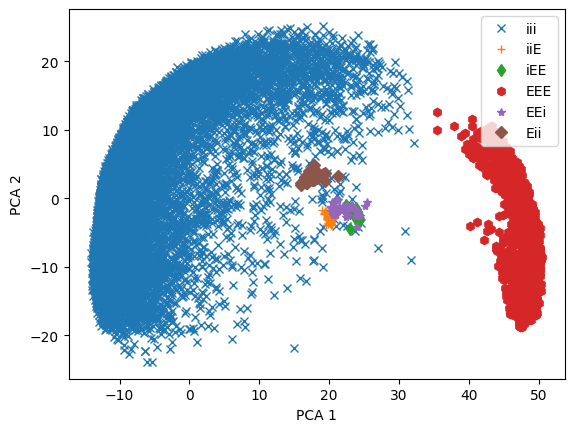

In [2]:
import matplotlib.pyplot as plt
from utils.seqlab import Index_Dictionary
import pandas as pd

# plot pca analysis
average_f1_score_1_token_analysis_pca_path = os.path.join("motif_analysis", "token_analysis", "average_f1_score_1_token_analysis_pca.csv")
df = pd.read_csv(average_f1_score_1_token_analysis_pca_path)
unique_prediction_ids = df["prediction_id"].unique().tolist()
markers = ['x', '+', 'd', 'h', '*', 'D']

# plot pca.
for i, j in zip(unique_prediction_ids, markers):
    filtered_df = df[df["prediction_id"] == i]
    x = filtered_df["nf-0"]
    y = filtered_df["nf-1"]
    plt.plot(
        x, 
        y,
        j,
        label=Index_Dictionary[i]
    )

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(loc="upper right")

plt.show()


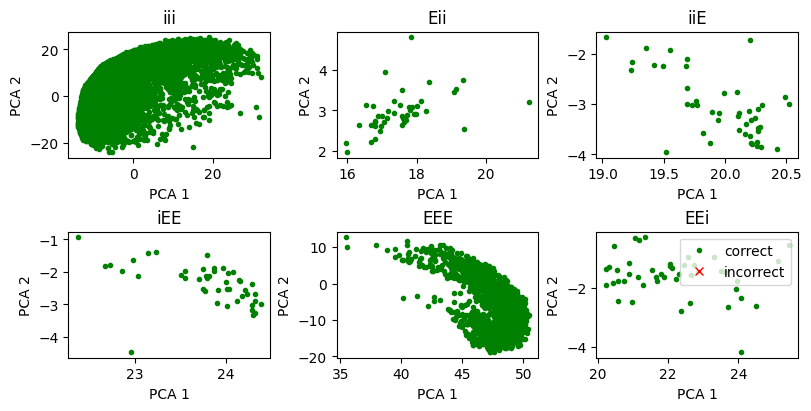

In [21]:
import pandas as pd
import os

nrows = 2
ncols = 3
idx = 0
df = pd.read_csv(os.path.join("motif_analysis", "token_analysis", "average_f1_score_1_token_analysis_pca.csv"))
figs, axes = plt.subplots(nrows, ncols, constrained_layout=True, figsize=(8, 4))
for r in range(nrows):
    for c in range(ncols):
        i = unique_prediction_ids[idx]
        j = markers[idx]
        filtered_df = df[df["prediction_id"] == i]
        correct_df = df[(df["prediction_id"] == i) & (df["target_id"] == i)]
        false_df = df[(df["prediction_id"] != i) & (df["target_id"] == i)]
        correct_x = correct_df["nf-0"]
        correct_y = correct_df["nf-1"]
        false_x = false_df["nf-0"]
        false_y = false_df["nf-1"]
        axes[r][c].plot(
            correct_x, 
            correct_y,
            '.',
            color="green",
            label=f"correct"
        )
        axes[r][c].plot(
            false_x, 
            false_y,
            'x',
            color="red",
            label=f"incorrect"
        )
        axes[r][c].set_xlabel("PCA 1")
        axes[r][c].set_ylabel("PCA 2")
        axes[r][c].set_title(f"{Index_Dictionary[i]}")
        idx += 1

plt.legend(loc="upper right")
plt.show()

In [4]:
# pca with sklearn.
# work in average F1 score 0.9 to 1.
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

average_f1_score_09_1_path = os.path.join("motif_analysis", "token_analysis", "average_f1_score_09_1_token_analysis.csv")
n_components = 2
avg_f1_score_09_1_df = pd.read_csv(average_f1_score_09_1_path)
print(avg_f1_score_09_1_df.shape)
avg_f1_score_09_1_feature_df = avg_f1_score_09_1_df[[f"feature-{i}" for i in range(768)]]
avg_f1_score_09_1_feature_std = (avg_f1_score_09_1_feature_df - avg_f1_score_09_1_feature_df.mean()) / avg_f1_score_09_1_feature_df.std()
avg_f1_score_09_1_feature_std.shape

(107520, 772)


(107520, 768)

In [5]:
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(avg_f1_score_09_1_feature_std)
principal_components_df = pd.DataFrame(data=principal_components, columns=[f"nf-{i}" for i in range(n_components)])
print(principal_components_df.shape)

(107520, 2)


In [6]:
principal_components_df.head(2)

,nf-0,nf-1
0,-7.604525,-5.115573
1,-10.060704,-1.852606


In [7]:
# merge dataset with pca features.
avg_f1_score_09_1_df["nf-0"] = principal_components_df["nf-0"]
avg_f1_score_09_1_df["nf-1"] = principal_components_df["nf-1"]
average_f1_score_09_1_token_analysis_pca_path = os.path.join("motif_analysis", "token_analysis", "average_f1_score_09_1_token_analysis_pca.csv")
avg_f1_score_09_1_df.to_csv(
    average_f1_score_09_1_token_analysis_pca_path,
    index=False
)

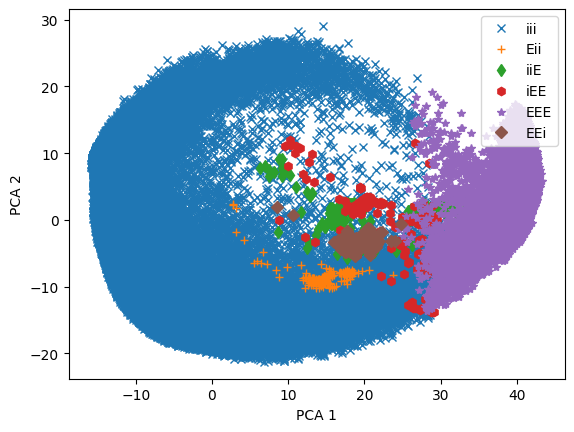

In [8]:
import matplotlib.pyplot as plt
from utils.seqlab import Index_Dictionary
import pandas as pd

# plot pca analysis
average_f1_score_09_1_token_analysis_pca_path = os.path.join("motif_analysis", "token_analysis", "average_f1_score_09_1_token_analysis_pca.csv")
df = pd.read_csv(average_f1_score_09_1_token_analysis_pca_path)
unique_prediction_ids = df["prediction_id"].unique().tolist()
markers = ['x', '+', 'd', 'h', '*', 'D']

# plot pca.
for i, j in zip(unique_prediction_ids, markers):
    filtered_df = df[df["prediction_id"] == i]
    x = filtered_df["nf-0"]
    y = filtered_df["nf-1"]
    plt.plot(
        x, 
        y,
        j,
        label=Index_Dictionary[i]
    )

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(loc="upper right")

plt.show()

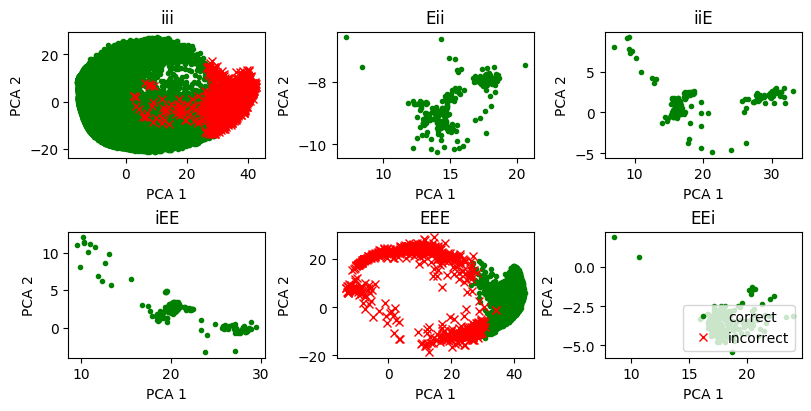

In [22]:
import pandas as pd
import os
from utils.seqlab import Index_Dictionary

df = pd.read_csv(os.path.join("analysis", "token_analysis", "average_f1_score_09_1_token_analysis_pca.csv"))
label_ids = Index_Dictionary.keys()
nrows = 2
ncols = 4
idx = 0
figs, axes = plt.subplots(nrows, ncols, constrained_layout=True, figsize=(8, 4))
for r in range(nrows):
    for c in range(ncols):
        i = label_ids[idx]
        filtered_df = df[df["prediction_id"] == i]
        correct_df = df[(df["prediction_id"] == i) & (df["target_id"] == i)]
        false_df = df[(df["prediction_id"] != i) & (df["target_id"] == i)]
        correct_x = correct_df["nf-0"]
        correct_y = correct_df["nf-1"]
        false_x = false_df["nf-0"]
        false_y = false_df["nf-1"]
        axes[r][c].plot(
            correct_x, 
            correct_y,
            '.',
            color="green",
            label=f"correct"
        )
        axes[r][c].plot(
            false_x, 
            false_y,
            'x',
            color="red",
            label=f"incorrect"
        )
        axes[r][c].set_xlabel("PCA 1")
        axes[r][c].set_ylabel("PCA 2")
        axes[r][c].set_title(f"{Index_Dictionary[i]}")
        # axes[r][c].legend(loc="upper right")
        idx += 1

plt.legend(loc="lower right")
plt.show()

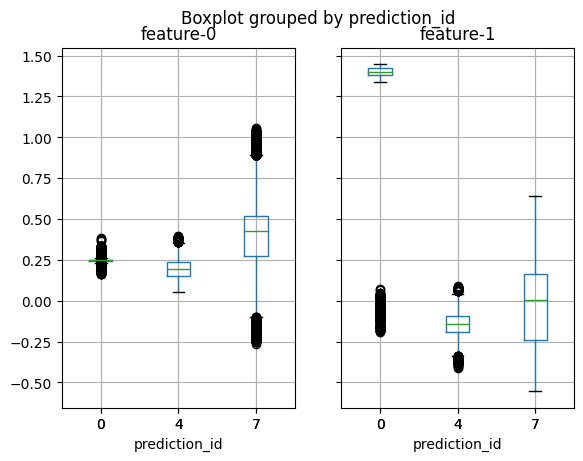

In [20]:
boxplot = df.boxplot(by="prediction_id", column=["feature-0", "feature-1"], layout=(1, 2))

array([<AxesSubplot:title={'center':'feature-1'}, xlabel='prediction_id'>,
       <AxesSubplot:title={'center':'feature-2'}, xlabel='prediction_id'>],
      dtype=object)

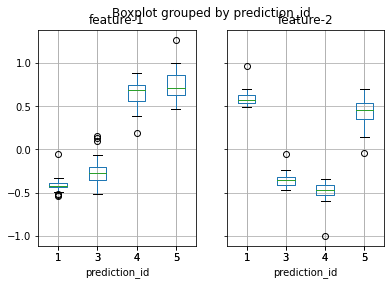

In [8]:
# load dataset.
from utils.seqlab import splice_site_ids, Index_Dictionary
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

token_reps_df = pd.read_csv(
    os.path.join("prediction", "log", "token_representation_analysis.csv")
)
ss_token_reps_df = token_reps_df[token_reps_df["prediction_id"].isin(splice_site_ids)]


array([<AxesSubplot:title={'center':'feature-1'}, xlabel='prediction_id'>,
       <AxesSubplot:title={'center':'feature-2'}, xlabel='prediction_id'>],
      dtype=object)

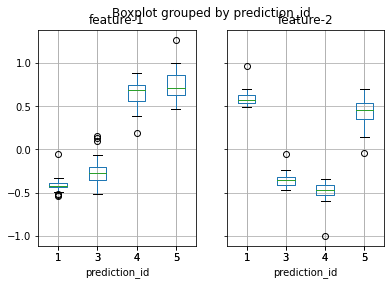

In [9]:
# boxplot.

X = ss_token_reps_df[[f"feature-{i}" for i in range(768)]].to_numpy()
labels = ss_token_reps_df["prediction_id"].to_numpy()
ss_token_reps_df.boxplot(by="prediction_id", column=["feature-1", "feature-2"])


eigen values and vector dimension (768,) (768, 768)
idx (768,), sorted eigen vector (768, 768)


c:\.virtualenv\sequence-processing\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


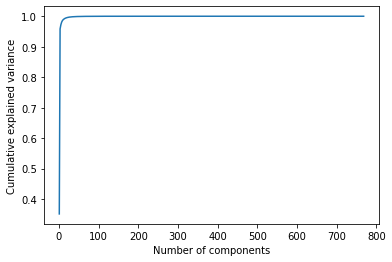

In [30]:
# compute covariance matrix.
X = StandardScaler().fit_transform(X)
cov = (X.T @ X) / (X.shape[0] - 1)

# performing eigen-decomposition.
eig_values, eig_vectors = np.linalg.eig(cov)
print("eigen values and vector dimension", eig_values.shape, eig_vectors.shape)

# determine which principal components to select.
idx = np.argsort(eig_values, axis=0)[::-1]
sorted_eig_vectors = eig_vectors[:, idx]
print(f"idx {idx.shape}, sorted eigen vector {sorted_eig_vectors.shape}")

cumsum = np.cumsum(eig_values[idx]) / np.sum(eig_values[idx])
xint = range(1, len(cumsum) + 1)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
# plt.xticks(xint)
# plt.xlim(1, 768, 1)
plt.plot(xint, cumsum)
plt.show()


In [1]:
# PCA
import os
import pandas as pd
from utils.pca import PCA_Util

path = os.path.join("analysis", "token_analysis", "average_f1_score_1_token_analysis_pca.csv")
dataframe = pd.read_csv(path)

pca = PCA_Util(dataframe, [f"feature-{i}" for i in range(768)])


<bound method NDFrame.head of        token_id  prediction_id  target_id  \
0             2              0       -100   
1            14              0          0   
2            42              0          0   
3            26              0          0   
4            26              0          0   
...         ...            ...        ...   
23035        10              0          0   
23036        25              0          0   
23037        21              0          0   
23038         6              0          0   
23039         3              0       -100   

                                              bert_value  feature-0  \
0      0.5987289547920227 1.5350109338760376 -1.13177...   0.598729   
1      0.645226776599884 1.1057463884353638 -0.988500...   0.645227   
2      0.6590502858161926 1.3099822998046875 -1.48484...   0.659050   
3      0.5989874601364136 1.3798731565475464 -1.27833...   0.598987   
4      0.6436380743980408 1.453780174255371 -1.338218...   0.643638   
...

In [2]:
pca.dataframe.head(5)

,token_id,prediction_id,target_id,bert_value,feature-0,feature-1,feature-2,feature-3,feature-4,feature-5,...,feature-760,feature-761,feature-762,feature-763,feature-764,feature-765,feature-766,feature-767,nf-0,nf-1
0,2,0,-100,0.5987289547920227 1.5350109338760376 -1.13177...,0.598729,1.535011,-1.131780,0.769095,1.701033,-0.424053,...,0.813483,-1.487175,-0.335770,-0.408056,0.352956,-1.638532,0.782630,-0.097833,-12.262528,-16.561008
1,14,0,0,0.645226776599884 1.1057463884353638 -0.988500...,0.645227,1.105746,-0.988500,1.048968,1.746609,-0.747095,...,0.764826,-1.077138,-0.266482,-0.474709,0.373477,-1.665863,0.762050,-0.301003,-10.811294,-11.292125
2,42,0,0,0.6590502858161926 1.3099822998046875 -1.48484...,0.659050,1.309982,-1.484845,0.960860,1.864745,-0.668480,...,0.895121,-1.292902,-0.188040,-0.621346,0.277545,-1.659615,0.878678,-0.224651,-11.445734,-11.369141
3,26,0,0,0.5989874601364136 1.3798731565475464 -1.27833...,0.598987,1.379873,-1.278331,1.004261,1.844381,-0.661428,...,1.007873,-1.188743,-0.202197,-0.699785,0.307036,-1.635817,0.751317,-0.356715,-11.862713,-11.122044
4,26,0,0,0.6436380743980408 1.453780174255371 -1.338218...,0.643638,1.453780,-1.338219,0.994284,1.844847,-0.643750,...,1.012343,-1.242443,-0.184286,-0.699384,0.279862,-1.641129,0.768689,-0.376701,-11.778899,-11.458162


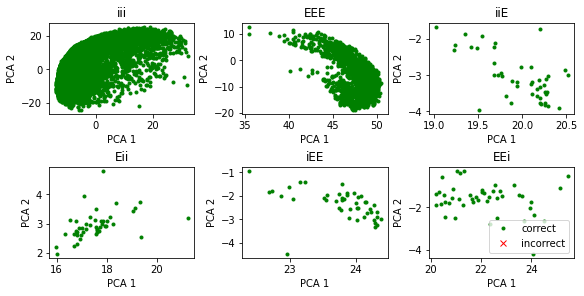

In [3]:
pca.plot(pca.dataframe)

In [ ]:
# compute the transformation.
eig_scores = np.dot(X, sorted_eig_vectors[:, :2])
colors = ["blue", "red", "green", "yellow", "gray", "black"]

print(eig_scores.shape)
def biplot(score, coeff, labels):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]

    for i, u in zip(splice_site_ids, [Index_Dictionary[a] for a in splice_site_ids]):
        print(i, u)
        xi = [
            score[j, 0] for j in range(score.shape[0]) if ss_token_reps_df["target_id"].tolist()[j] == u
        ]
        yi = [
            score[j, 1] for j in range(score.shape[0]) if ss_token_reps_df["target_id"].tolist()[j] == u
        ]
        plt.scatter(xi, yi, c=colors[i], label=u)
    for i in range(n):
        plt.arrow(
            0, 0, coeff[i, 0], coeff[i, 1], color="r", head_width=0.05, head_length=0.1
        )
        plt.text(
            coeff[i, 0] * 1.35,
            coeff[i, 1] * 1.35,
            labels[i],
            color="g",
            ha="center",
            va="center",
        )


plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

biplot(eig_scores, sorted_eig_vectors, [f"feature-{i}" for i in range(768)])
plt.legend()

In [20]:
ndf[ndf["comparison"] == 0]

,token,target,prediction,bert_value,comparison
1,GAA,iEE,iiE,0.3126485049724579 -1.088175892829895 -0.56700...,0
2,AGG,EEi,Eii,-0.1707116961479187 0.4697659909725189 1.07950...,0
3,GGT,Eii,iiE,-0.8013615608215332 0.10018081218004227 1.5437...,0
4,AGG,iiE,Eii,-0.11103878915309906 -0.24303054809570312 1.02...,0
5,GGA,iEE,iiE,-0.06882086396217346 0.0999293401837349 1.1488...,0
...,...,...,...,...,...
175,GGT,Eii,iiE,-0.12136223912239075 0.24540439248085022 1.074...,0
176,AGG,iiE,Eii,0.19183388352394104 -0.3378389775753021 0.5174...,0
177,GGA,iEE,EEE,0.17814867198467255 -0.09485137462615967 1.077...,0
178,AGG,EEi,EEE,0.021793914958834648 0.720974862575531 0.61671...,0


In [19]:
ndf.to_csv(
    os.path.join("motif_analysis", "token_analysis", "df-F1=1.csv"), 
    index=False
)

In [21]:
# something weird.
import os
import pandas as pd

path = os.path.join("prediction", "dataframe-F1 Score=1.csv")
tokens, predictions, targets = [], [], []
df = pd.read_csv(path)
for step, r in df.iterrows():
    input_tokens = r["input_tokens"].split(" ")
    prediction_tokens = r["prediction_tokens"].split(" ")
    target_tokens = r["target_tokens"].split(" ")

    for i, j, k in zip(input_tokens, prediction_tokens, target_tokens):
        tokens.append(i)
        predictions.append(j)
        targets.append(k)

df = pd.DataFrame(data={
    "token": tokens,
    "prediction": predictions,
    "target": targets
})
df.head(5)

,token,prediction,target
0,ACT,iii,iii
1,CTT,iii,iii
2,TTT,iii,iii
3,TTT,iii,iii
4,TTC,iii,iii


In [23]:
print(df.shape)
print(df[df["prediction"] == df["target"]].shape)
print(df[df["prediction"] != df["target"]].shape)

(22950, 3)
(22950, 3)
(0, 3)
